In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CSV_DATA = Path().cwd().parent.parent / "data/2_loaded"

In [2]:
df = pd.read_csv(CSV_DATA/'summary/ride_summary_good.csv')
df['start_date'] = pd.to_datetime(df['start_date'])
df['year'] = df['start_date'].dt.year
df['month'] = df['start_date'].dt.month
df['month_name'] = df['start_date'].dt.month_name()
df['start_time'] = pd.to_timedelta(df['start_time'])
df['end_time'] = pd.to_timedelta(df['end_time'])

In [3]:
power_cols = ['best_power_4s', 'best_power_5s','best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                    'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                    'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                    'best_power_40m', 'best_power_1h']

In [4]:
import re
def get_power_curves(df_summary:pd.DataFrame, ride_id_subset:list[str]=None) -> pd.DataFrame:
    # Subset the df_summary columns and filter for the relevant ride_ids
    cols_of_interest = ['ride_id', 'start_date','year','month','month_name', 'total_distance_mi','total_ascent_ft','avg_power']
    power_cols = ['best_power_4s', 'best_power_5s','best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                    'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                    'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                    'best_power_40m', 'best_power_1h']
    cols_of_interest += power_cols
    if ride_id_subset is None: ride_id_subset = df['ride_id'].values # if not specified, all rides will be used
    df_rides = df_summary.copy().loc[df_summary['ride_id'].isin(ride_id_subset), cols_of_interest]

    # Create a mapping from power column names back to axis labels and values
    power_col_map = get_power_column_mapping(power_cols)

    # For each ride, plot its power curve
    df_powers = []
    for _, row in df_rides.iterrows():
        data = [{'duration':power_col_map[col]['duration'], 'best_power':row[col]} for col in power_cols]
        df_pwr = pd.DataFrame(data)
        df_pwr['ride_id']=row['ride_id']
        df_pwr['year']=row['year']
        df_pwr['month']=row['month']
        df_pwr['month_name']=row['month_name']
        df_pwr = df_pwr[['ride_id','year','month','month_name','duration','best_power']]
        df_powers.append(df_pwr)

    return pd.concat(df_powers, ignore_index=True)

def get_power_column_mapping(power_cols:list[str]) -> dict:
    # Create a mapping from power column names back to axis labels and values
    pattern = r'best_power_([\d]+)([smh])'
    seconds_map = {'s':1, 'm':60, 'h':60*60}
    power_col_map = dict()
    for col in power_cols:
        matched = re.match(pattern, col)
        if matched is not None:
            value, unit = matched.groups()
            power_col_map[col] = {'label':value+unit,'duration':int(value)*seconds_map[unit]}
    return power_col_map

def get_top_cyclists_power_curve() -> pd.DataFrame:
    power_col_map = get_power_column_mapping(power_cols)
    # top 1% of cyclists, ref: https://www.cyclinganalytics.com/blog/2018/06/how-does-your-cycling-power-output-compare
    top_cyclist_powers = {'best_power_4s':1650, 'best_power_5s':1500,'best_power_10s':1375, 'best_power_20s':1200, 'best_power_30s':1000, 'best_power_1m':775,
                        'best_power_2m':600, 'best_power_3m':560, 'best_power_4m':535, 'best_power_5m':510,
                        'best_power_6m':500, 'best_power_10m':490, 'best_power_20m':460, 'best_power_30m':420,
                        'best_power_40m':375, 'best_power_1h':360}
    data = [{'duration':power_col_map[col]['duration'], 'best_power':top_cyclist_powers[col]} for col in top_cyclist_powers.keys()]
    df_pwr_top = pd.DataFrame(data)
    return df_pwr_top

In [5]:
def plot_summary_power_curves(df_pwrs:pd.DataFrame, figsize:tuple=(12,4), color_by:str='ride_id', alpha:float=0.5, ylims:list[float]=None,
                              logscale_base:int=10, title:str='Best Ride Efforts Power Curve', show_best_cyclist_curve:bool=True):
    ########################################################################
    # Create the Figure
    fig, ax = plt.subplots(1,1, figsize=figsize)

    # For each ride, plot its power curve
    plot_kwargs = dict(data=df_pwrs, x='duration', y='best_power', ax=ax, alpha=alpha,legend=False, hue=color_by)
    if color_by!='ride_id':
        plot_kwargs['legend']=True
        plot_kwargs['palette']='tab10'
    _ = sns.lineplot(**plot_kwargs)
    plot_kwargs['legend']=False # do not record dots in the legend
    _ = sns.scatterplot(**plot_kwargs)
    

    if show_best_cyclist_curve:
        df_pwr_top = get_top_cyclists_power_curve()
        _ = ax.plot(df_pwr_top['duration'],df_pwr_top['best_power'], alpha=0.8, c='red', linestyle='--')
        _ = ax.scatter(df_pwr_top['duration'],df_pwr_top['best_power'],label='Top 99% Cyclist', alpha=0.8, marker='d', c='red', linewidths=2)
        _ = plt.legend(loc='best')
    

    ########################################################################
    # Set the axes up for plotting
    def forward(x):
        return np.log10(x) / np.log10(logscale_base)

    def inverse(x):
        return logscale_base**x
    
    if logscale_base==10:
        _ = ax.set_xscale('log')
    else:
        _ = ax.set_xscale('function', functions=(forward,inverse))
    power_col_map = get_power_column_mapping(power_cols)
    _ = plt.xticks(ticks=[col['duration'] for col in power_col_map.values()], 
                   labels=[col['label'] for col in power_col_map.values()], rotation=45)
    _ = plt.grid()
    _ = ax.set_axisbelow(True)
    _ = plt.xlabel('Effort Time Duration', fontsize=14)
    _ = plt.ylabel('Maximum Effort Power (W)', fontsize=14)
    _ = plt.title(title, fontsize=18)
    _ = plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left')
    _ = plt.tight_layout()
    if ylims is not None:
        _ = plt.ylim(ylims)

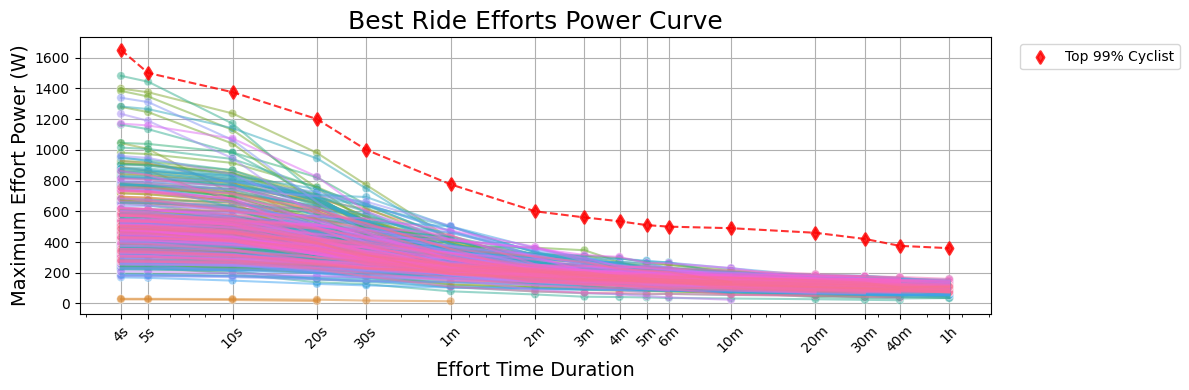

In [6]:
df_pwrs = get_power_curves(df_summary=df)
plot_summary_power_curves(df_pwrs=df_pwrs)

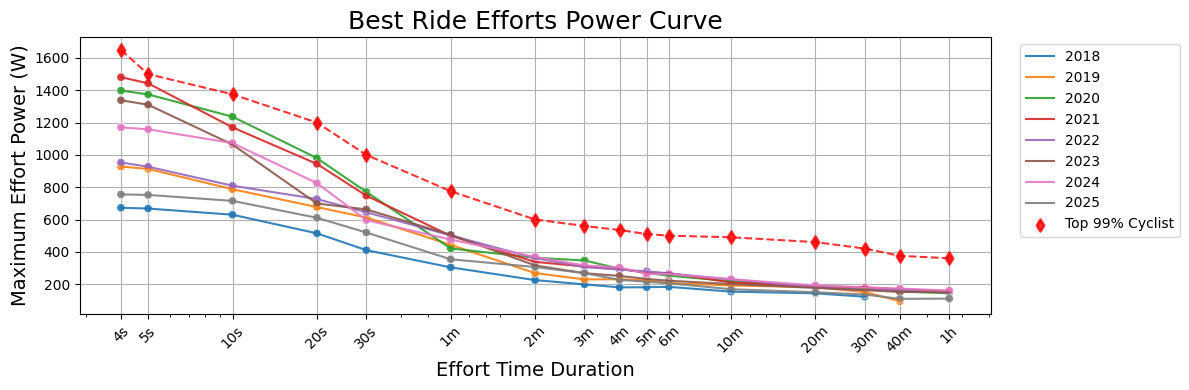

In [7]:
df_pwrs_by_year = df_pwrs[['year','duration','best_power']].groupby(['year','duration']).max()
plot_summary_power_curves(df_pwrs=df_pwrs_by_year, color_by='year', alpha=0.9, ylims=None)

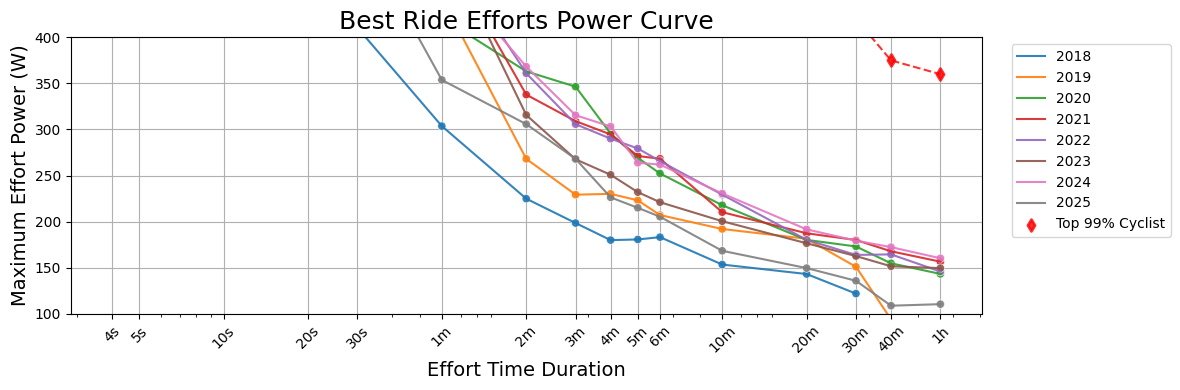

In [8]:
plot_summary_power_curves(df_pwrs=df_pwrs_by_year, color_by='year', alpha=0.9, ylims=[100,400])

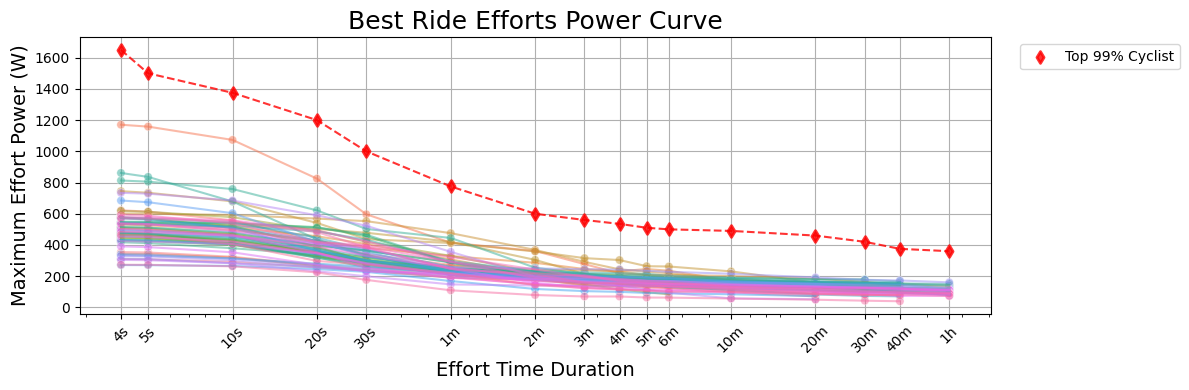

In [9]:
df_pwrs_2024 = df_pwrs.loc[df_pwrs['year']==2024,:]
plot_summary_power_curves(df_pwrs=df_pwrs_2024)

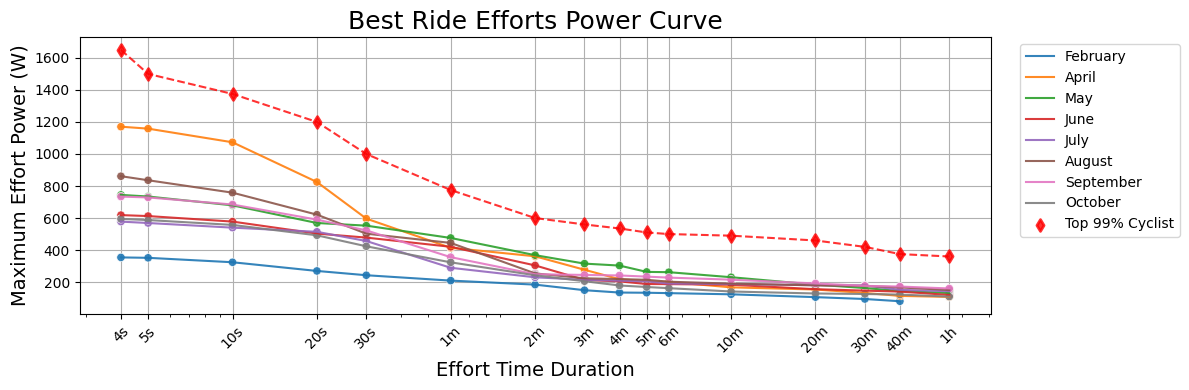

In [10]:
df_pwrs_2024_by_month = df_pwrs_2024[['month','month_name','duration','best_power']].groupby(['month','month_name','duration']).max()
plot_summary_power_curves(df_pwrs=df_pwrs_2024_by_month, color_by='month_name', alpha=0.9, ylims=None)

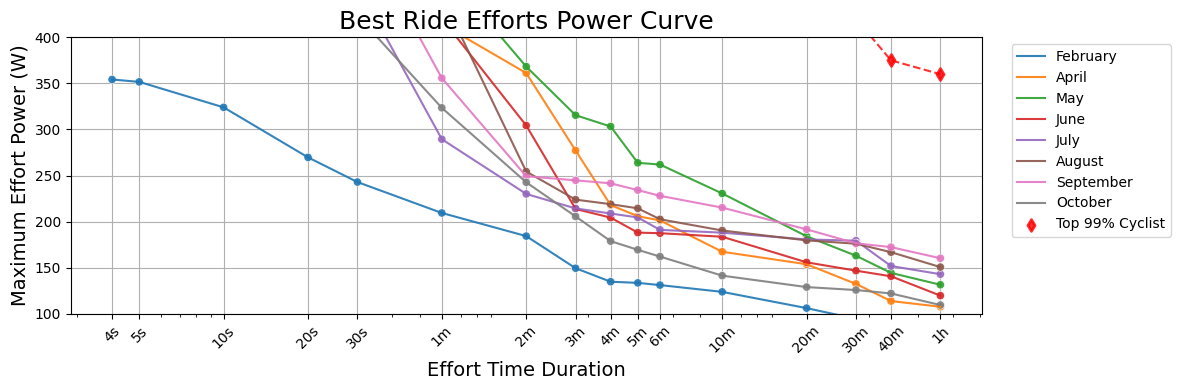

In [11]:
plot_summary_power_curves(df_pwrs=df_pwrs_2024_by_month, color_by='month_name', alpha=0.9, ylims=[100,400])

In [12]:
df_pwr_pivot = pd.pivot_table(df_pwrs_2024_by_month.reset_index(), values='best_power', columns='month_name', index='duration')

In [13]:
df_pwr_pivot

month_name,April,August,February,July,June,May,October,September
duration,,,,,,,,
4,1170.473521,861.320226,354.250825,577.740871,618.382047,744.631330,594.634267,733.961925
5,1158.334870,836.066895,351.659801,569.040480,612.428101,734.497080,587.501714,728.710193
10,1073.148701,758.485988,324.016790,540.094573,577.929987,679.351453,557.130115,684.541153
20,825.049190,621.307550,269.726666,514.129401,502.955164,569.112684,492.173564,590.090947
30,596.478742,502.425945,242.969958,456.624604,477.955158,552.564718,423.619541,523.005521
60,414.423510,444.784638,209.420901,289.461902,420.486590,475.708726,323.496736,355.777049
120,361.223633,254.321654,184.329614,230.071239,304.294777,368.238988,242.687937,249.263725
180,277.179928,223.891134,149.468923,214.341872,213.729911,315.488671,205.661610,244.839911
240,217.968068,218.977439,134.825479,208.835193,204.393857,303.259288,178.850777,241.582320


In [18]:
month_number= {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
for month in month_number.keys():
    if month not in df_pwr_pivot.columns:
        df_pwr_pivot[month]=0.0
df_pwr_pivot = df_pwr_pivot[month_number.keys()]
df_pwr_pivot = df_pwr_pivot.fillna(0.0)

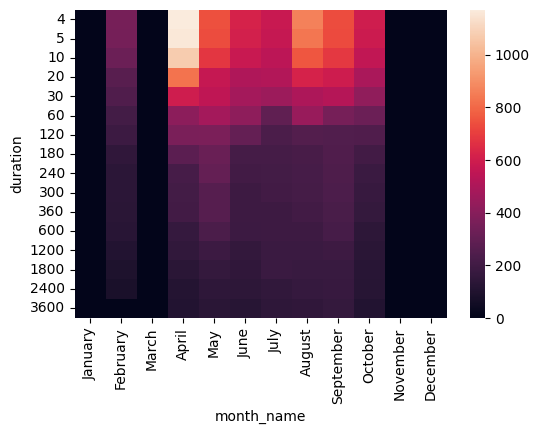

In [ ]:
_ = plt.figure(figsize=(6,4))
_ = sns.heatmap(df_pwr_pivot) # need to use a logarithmic colorscale

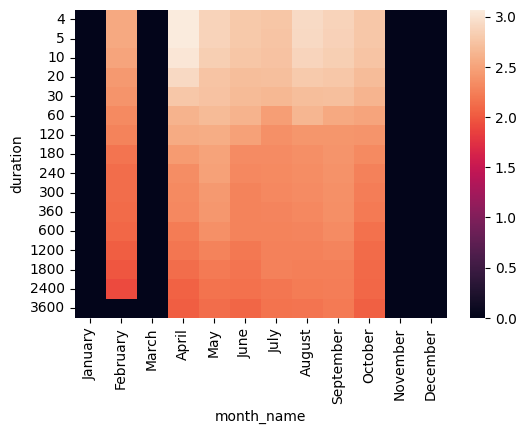

In [23]:
_ = plt.figure(figsize=(6,4))
_ = sns.heatmap(df_pwr_pivot.apply(lambda x: np.log10(x+1))) # need to use a logarithmic colorscale